In [19]:
import sys
sys.path.append("../") # This version of the notebook is in the subfolder "notebooks" of the repo

import gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from copy import deepcopy

from mbt_gym.gym.TradingEnvironment import TradingEnvironment, ASSET_PRICE_INDEX, INVENTORY_INDEX
from mbt_gym.gym.Traders import AmmTrader, MarketOrderTrader

from mbt_gym.agents.BaselineAgents import *
from mbt_gym.gym.helpers.generate_trajectory import generate_trajectory
from mbt_gym.gym.helpers.plotting import *
from mbt_gym.agents.BaselineAgents import CarteaJaimungalMmAgent
from mbt_gym.gym.helpers.generate_trajectory import generate_trajectory
from mbt_gym.gym.StableBaselinesTradingEnvironment import StableBaselinesTradingEnvironment
from mbt_gym.gym.wrappers import *
from mbt_gym.rewards.RewardFunctions import CjCriterion, CjMmCriterion
from mbt_gym.stochastic_processes.midprice_models import *
from mbt_gym.stochastic_processes.fill_probability_models import *
from mbt_gym.stochastic_processes.arrival_models import *
import torch

In [20]:

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
terminal_time = 1.0
arrival_rate = 50.0
n_steps = int(10 * terminal_time * arrival_rate)
phi = 0.005
alpha = 0.001
seed = 1
num_trajectories = 1

### Pool envrionement and agent

In [80]:
fill_exponent = 1
initial_inventory_pool = 100
initial_price = 100
unit_size = 1
max_depth = 5*1/fill_exponent
step_size = terminal_time/n_steps

midprice_model_internal = AmmSelfContainedMidpriceModel(jump_size_L=1, 
                                       unit_size = unit_size,
                                       terminal_time=terminal_time, 
                                           step_size=step_size, 
                                           initial_price=initial_price, 
                                           num_trajectories=num_trajectories, seed = seed)
arrival_model = PoissonArrivalModel(intensity=np.array([arrival_rate, arrival_rate]), step_size=step_size, seed = seed)
fill_probability_model = ExponentialFillFunction(fill_exponent=fill_exponent, 
                                                           step_size=step_size, 
                                                           num_trajectories=num_trajectories, seed = seed)
AMMtrader = AmmTrader(midprice_model = midprice_model_internal, 
                      arrival_model = arrival_model, 
                    fill_probability_model = fill_probability_model,
                    num_trajectories = num_trajectories, max_depth = max_depth, unit_size = unit_size)



env_params_pool = dict(terminal_time    = terminal_time, 
                      n_steps           = n_steps,
                      initial_inventory = initial_inventory_pool,
                      midprice_model    = midprice_model_internal,
                      arrival_model     = arrival_model,
                      fill_probability_model = fill_probability_model,
                      trader            = AMMtrader,
                      reward_function   = CjMmCriterion(phi, alpha),
                      normalise_action_space = False,
                      normalise_observation_space = False,
                      num_trajectories = num_trajectories)


pool_env   = TradingEnvironment(**env_params_pool)
pool_agent = PoolMmAgent(env=pool_env)

In [81]:
pool_agent.get_action(pool_agent.env.state.copy())



min inventory=  0 , max inventory: 200
pool inventory =  [100.]

pool index =  100
max index =  200


array([[0.23454344, 1.77526922]])

### Arbitrageur AMM agent 

In [82]:
sigma = 10
initial_inventory_arb = 0

midprice_model_external = BrownianMotionMidpriceModel(volatility  = sigma,
                                                    initial_price = initial_price,
                                                    terminal_time = terminal_time,
                                                    step_size     = step_size,
                                                    num_trajectories = num_trajectories,
                                                    seed = seed)

ArbTrader = MarketOrderTrader(num_trajectories  = 1,
                              min_size  = -10,
                              max_size  = 10,
                              seed  = seed)

env_params_arb = dict(terminal_time     = terminal_time, 
                      n_steps            =n_steps,
                      initial_inventory = initial_inventory_arb,
                      midprice_model    = midprice_model_external,
                      trader            = ArbTrader,
                      reward_function   = CjMmCriterion(phi, alpha),
                      normalise_action_space = False,
                      normalise_observation_space = False,
                      num_trajectories = num_trajectories)

arb_env   = TradingEnvironment(**env_params_arb)
arb_agent = ArbitrageurAmmAgent(env   = TradingEnvironment(**env_params_arb),
                                agent = pool_agent)

### Simulation

In [83]:
import gym
import numpy as np
import torch

from mbt_gym.agents.Agent import Agent

#def generate_trajectory(env: gym.Env, agent: Agent, seed: int = None, include_log_probs: bool = False):
pool_env.seed(seed)
arb_env.seed(seed)
    
obs_space_dim    = arb_env.observation_space.shape[0]
action_space_dim = arb_env.action_space.shape[0]
observations     = np.zeros((arb_env.num_trajectories, obs_space_dim, arb_env.n_steps + 1))
actions          = np.zeros((arb_env.num_trajectories, action_space_dim, arb_env.n_steps))
rewards          = np.zeros((arb_env.num_trajectories, 1, arb_env.n_steps))

obs                   = arb_env.reset()
observations[:, :, 0] = obs
count                 = 0

for _i in range(100):
    action = arb_agent.get_action(obs)
    obs,      reward, done, _          = arb_env.step(action)
    
    actions[:, :, count]          = action
    observations[:, :, count + 1] = obs
    rewards[:, :, count]          = reward.reshape(-1, 1)
    
    if (pool_env.num_trajectories > 1 and done[0]) or (pool_env.num_trajectories == 1 and done):
        break
        
    count += 1



min inventory=  0 , max inventory: 200
pool inventory =  [100.]

pool index =  100
max index =  200
S =  [[100]] , Z= [[100]]  deltas =  [[0.23454344 1.77526922]]    *** action =  0


min inventory=  0 , max inventory: 200
pool inventory =  [100.]

pool index =  100
max index =  200
S =  [[100.08454724]] , Z= [[100.]]  deltas =  [[0.23392763 1.77587378]]    *** action =  0


min inventory=  0 , max inventory: 200
pool inventory =  [100.]

pool index =  100
max index =  200
S =  [[99.85076703]] , Z= [[100.]]  deltas =  [[0.23331194 1.7764782 ]]    *** action =  0


min inventory=  0 , max inventory: 200
pool inventory =  [100.]

pool index =  100
max index =  200
S =  [[99.6660394]] , Z= [[100.]]  deltas =  [[0.23269636 1.77708249]]    *** action =  0


min inventory=  0 , max inventory: 200
pool inventory =  [100.]

pool index =  100
max index =  200
S =  [[98.57418199]] , Z= [[100.]]  deltas =  [[0.23208091 1.77768665]]    *** action =  0


min inventory=  0 , max inventory: 200
poo



min inventory=  0 , max inventory: 200
pool inventory =  [83.]

pool index =  117
max index =  200
S =  [[99.98622883]] , Z= [[100.18530924]]  deltas =  [[0.04836594 1.96075671]]    *** action =  0


min inventory=  0 , max inventory: 200
pool inventory =  [83.]

pool index =  117
max index =  200
S =  [[100.49091972]] , Z= [[100.18530924]]  deltas =  [[0.04795925 1.96115189]]    *** action =  1


min inventory=  0 , max inventory: 200
pool inventory =  [82.]

pool index =  118
max index =  200
S =  [[100.95372597]] , Z= [[100.19735744]]  deltas =  [[0.03845347 1.97063872]]    *** action =  1


min inventory=  0 , max inventory: 200
pool inventory =  [81.]

pool index =  119
max index =  200
S =  [[100.31927939]] , Z= [[100.20955256]]  deltas =  [[0.02897869 1.98009454]]    *** action =  1


min inventory=  0 , max inventory: 200
pool inventory =  [80.]

pool index =  120
max index =  200
S =  [[100.3879633]] , Z= [[100.22189824]]  deltas =  [[0.01953492 1.98951937]]    *** action = 



min inventory=  0 , max inventory: 200
pool inventory =  [37.]

pool index =  163
max index =  200
S =  [[100.60820784]] , Z= [[100.98579129]]  deltas =  [[-0.35714846  2.36538886]]    *** action =  0


min inventory=  0 , max inventory: 200
pool inventory =  [37.]

pool index =  163
max index =  200
S =  [[100.29386682]] , Z= [[100.98579129]]  deltas =  [[-0.35699393  2.36522366]]    *** action =  0


min inventory=  0 , max inventory: 200
pool inventory =  [37.]

pool index =  163
max index =  200
S =  [[99.9907069]] , Z= [[100.98579129]]  deltas =  [[-0.3568378   2.36505683]]    *** action =  0


In [63]:
exog_prices

array([[100.        , 100.08454724,  99.85076703,  99.6660394 ,
         98.57418199,  99.3790356 ,  99.89072214,  99.74518862,
        100.09124545, 100.21700668,  99.96932958, 100.40651103,
        100.26762592, 100.1205714 ,  99.7663126 ,  99.96977604,
         99.92541332, 100.16927385,  99.89773215,  99.95445129,
         99.5554142 ,  99.93172878, 100.01582063, 100.16365647,
        100.34723941,  99.89521491, 100.2454641 , 101.16524956,
        100.4325158 ,  99.65909948,  98.98611841,  99.36243027,
         99.41999366,  99.90224306, 100.22532397, 100.31949455,
        100.44652027, 100.37060106, 100.75898828, 100.25376394,
        100.06510294, 100.17374849, 100.97936839, 100.63748965,
        100.15491914,  99.90300945, 100.33648115, 100.2313835 ,
        100.82364949,  99.98622883, 100.49091972, 100.95372597,
        100.31927939, 100.3879633 , 100.93166664, 100.97098523,
        101.4180653 , 102.48014701, 102.60265324, 102.47726246,
        102.13243745, 102.42226075, 102.

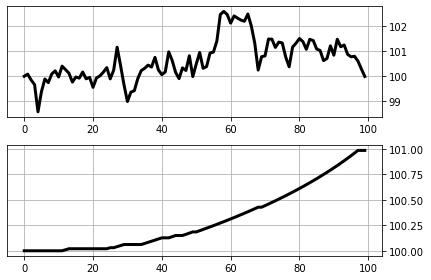

In [84]:
fig, (ax1, ax2) = plt.subplots(2, 1)

exog_prices = observations[:, ASSET_PRICE_INDEX, :]

time_space = np.linspace(0, terminal_time, len(exog_prices[0]))

ax1.plot(exog_prices[0][:100], lw=3, color='k')
ax2.plot([s[0][0] for s in arb_agent.historical_pool_prices][:100], lw=3, color='k')

for ax in (ax1, ax2): 
    ax.grid('both')
    ax.yaxis.tick_right()
plt.tight_layout()
plt.show()

In [ ]:
observations, actions, rewards